<a href="https://colab.research.google.com/github/sysyJEON/class_ai4ml/blob/main/ml_guide/ch04_Classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.5 GBM(Gradient Boosting Machine)

### GBM의 개요 및 실습

부스팅 알고리즘
- 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 대표적인 구현은 AdaBoost(Adaptive boosting)와 GBM(Gradient Boost Machine)

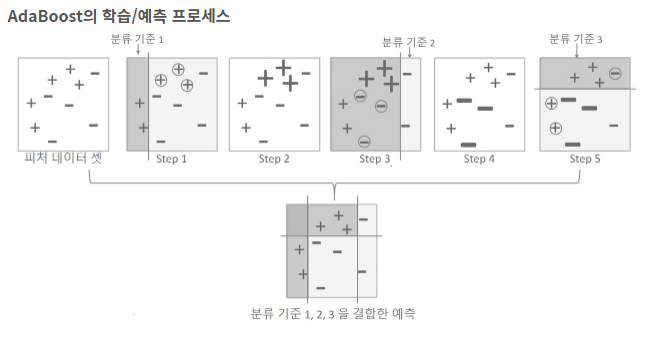

- Step 1: 첫번째 약한 학습기가 분류 기준 1로 +와 -를 분류한 것. 동그라미로 표시된 + 데이터는 잘못 분류된 오류 데이터
- Step 2: 오류 데이터에 가중치 값 부여되어 다음 약한 학습기가 더 잘 분류할 수 있게 크기가 커짐
- Stepr 3: 두번째 약한 학습기가 분류 기준 2로 분류

...

- 맨 아래: 첫 번째, 두 번째, 세 번째 약한 학습기를 모두 결합한 결과 예측

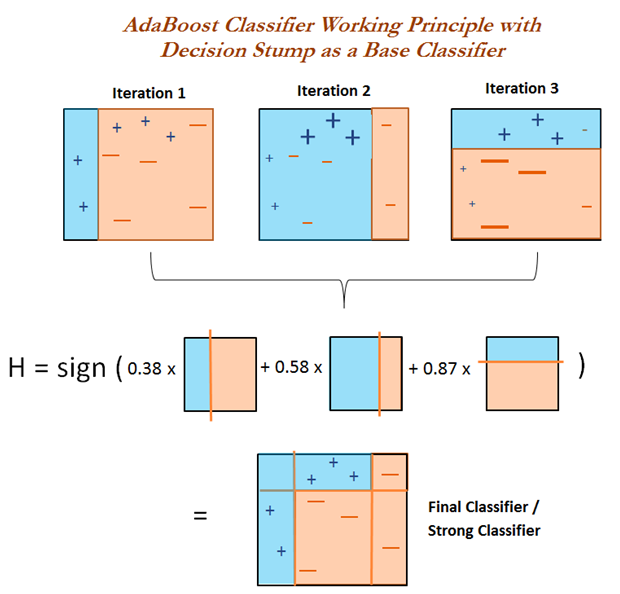

- 개별 약한 학습기는 위와 같이 각각 가중치를 부여해 결합
- 첫 번째 학습기에 가중치 0.38, 두 번째에 0.58, 세 번째에 0.87을 부여한 후 모두 결합해 예측 수행

GBM도 유사하나, 가중치 업데이트를 경사하강법(Gradient Descent)을 이용하는 것이 큰 차이
- 오류 값 = 실제 값 - 예측 값
- 오류식 h(x) = y - F(x) 를 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것이 경사 하강법
- 분류, 회귀 가능

사이킷런 GBM 기반 분류 `GradientBoostingClassifier` 클래스 제공

In [5]:
# data set 불러오기

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
# data set 불러오기

import pandas as pd

def get_human_dataset( ):

    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('/content/drive/MyDrive/데이터/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/데이터/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/content/drive/MyDrive/데이터/human_activity/test/X_test.txt',sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/데이터/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/데이터/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 1203.6 초 


### GBM 하이퍼 파라미터 소개

`loss`: 경사 하강법에서 사용할 비용함수 지정. 디폴트는 'deviance'
- 만든 모델이 실제 정답과 얼마나 다른지 측정하는 수단


`learning_rate`
- GBM이 학습 진행할 때마다 적용하는 학습률
- Weak learner가 순차적으로 오류 값을 보정해 나가는데 적용하는 계수
- 0 ~ 1  사이 값 지정, 기본값은 0.1
- 작으면 업데이트 값 작아져 최소 오류 값 찾아 예측 성능 높아질 가능성 높으나 수행 시간 오래 걸림
- 크면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능 떨어지지만 빠른 수행 가능
- 따라서 `n_estimators`와 상호 보완적으로 조합해 사용
- `learning_rate` 작게, `n_estimators` 크게 하면 더 이상 성능이 좋아지지 않는 한계점까지 예측 성능이 조금씩 좋아진다. 하지만 수행 시간 오래 걸림

`n_estimators`
- weak learner의 개수
- weak learner가 순차적으로 오류 보정하므로 개수 많을수록 예측 성능 좋아짐. 시간 오래 걸림. 기본값은 100

`subsample`
- weak learner가 학습에 사용하는 데이터의 샘플링 비율
- 기본값 1: 전체 학습 데이터를 기반으로 학습한다는 의미
- 과적합 염려되면 1보다 작은 값으로 설정

## 4.6 XGBoost(eXtra Gradient Boost)

GBM에 기반하지만, GBM의 단점인 느린 수행 시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결해서 매우 각광 받음

In [9]:
import xgboost

print(xgboost.__version__)

2.1.1


### 파이썬 래퍼 XGBoost 적용 – 위스콘신 유방암 예측

위스콘신 유방암 데이터 세트는 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)인지 양성 종양(benign)인지 분류하는 데이터 세트

In [10]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


타깃 레이블 값의 종류
- 악성인 'malignant'가 0, 양성인 'benign'이 1

In [11]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


- 1(양성 benign) 357개
- 0(악성 malignant) 212개

80% 학습용(90% 최종 학습용, 10% 검증용으로 분할), 20% 테스트용으로 추출
- XGBoost 기능 중 검증 성능 평가와 조기 중단(early stopping) 수행 위해 검증용 데이터 세트를 별도로 분할

In [12]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )
print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


- 전체 569개 데이터 세트에서 최종 학습용 409개, 검증용 46개, 테스트용 114개 추출

XGBoost만의 전용 데이터 객체인 DMatrix 사용
- 학습, 검증, 테스트 데이터를 모두 전용의 데이터 객체인 DMatrix로 생성하여 모델에 입력해줘야 함
- 주요 입력 파라미터는 data(피처 데이터 세트)와 label(분류: 레이블 데이터 세트, 회귀: 숫자형 종속값 데이터 세트)

In [13]:
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

XGBoost 하이퍼 파라미터 설정(주로 딕셔너리 형태로)
- max_depth 트리 최대 깊이 3
- 학습률 eta 0.1
- 예제 데이터가 0 또는 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic)
- 오류 함수의 평가 성능 지표는 logloss
- num_rounds(부스팅 반복 횟수)는 400회

In [14]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

XGBoost 모델 학습

In [19]:
# 평가용 데이터 세트 설정
eval_list = [(dtr,'train'),(dval,'eval')] # 학습 DMatrix, 검증 DMatrix

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds ,
                      # num_boost_round는 GBM의 n_estimators(랜덤 포레스트에서 결정 트리의 개수를 지정)와 같은 파라미터
                      early_stopping_rounds=50, evals=eval_list )
# 조기 중단 수행 위해 반드시 평가용 데이터 세트 지정과 eval_metric 함께 설정(eval_metric는 위 params 딕셔너리로 지정됨)
# 학습 반복 시마다 evals에 설정된 데이터 세트에 대해 평가 지표 결과가 출력됨

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

- 반복 시마다 train-logloss와 eva-logloss가 지속적으로 감소
- num_boost_round 400회 설정해도 끝까지 안 함

테스트 데이터 세트에 예측 수행
- `predict()` 메서드 이용
- 사이킷런의 `predict()` 메서드는 예측 결과 클래스 값(즉, 0, 1)을 반환하지만 xgboost의 `predict()`는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 **확률 값을 반환**
- 예제는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값 결정하는 로직 추가 필요

In [20]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


모델 예측 성능 평가

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
get_clf_eval(y_test , preds, pred_probs) # y_test(테스트 실제 레이블 값), preds(예측 레이블), pred_probs(예측 확률)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9965


xgboost 패키지 내장 시각화 기능 수행
- `plot_importance()` 속성
- 기본 평가 지표로 f스코어 기반
- f스코어: 해당 피처가 트리 분할 시 얼마나 자주 사용되었는지를 지표로 나타낸 값

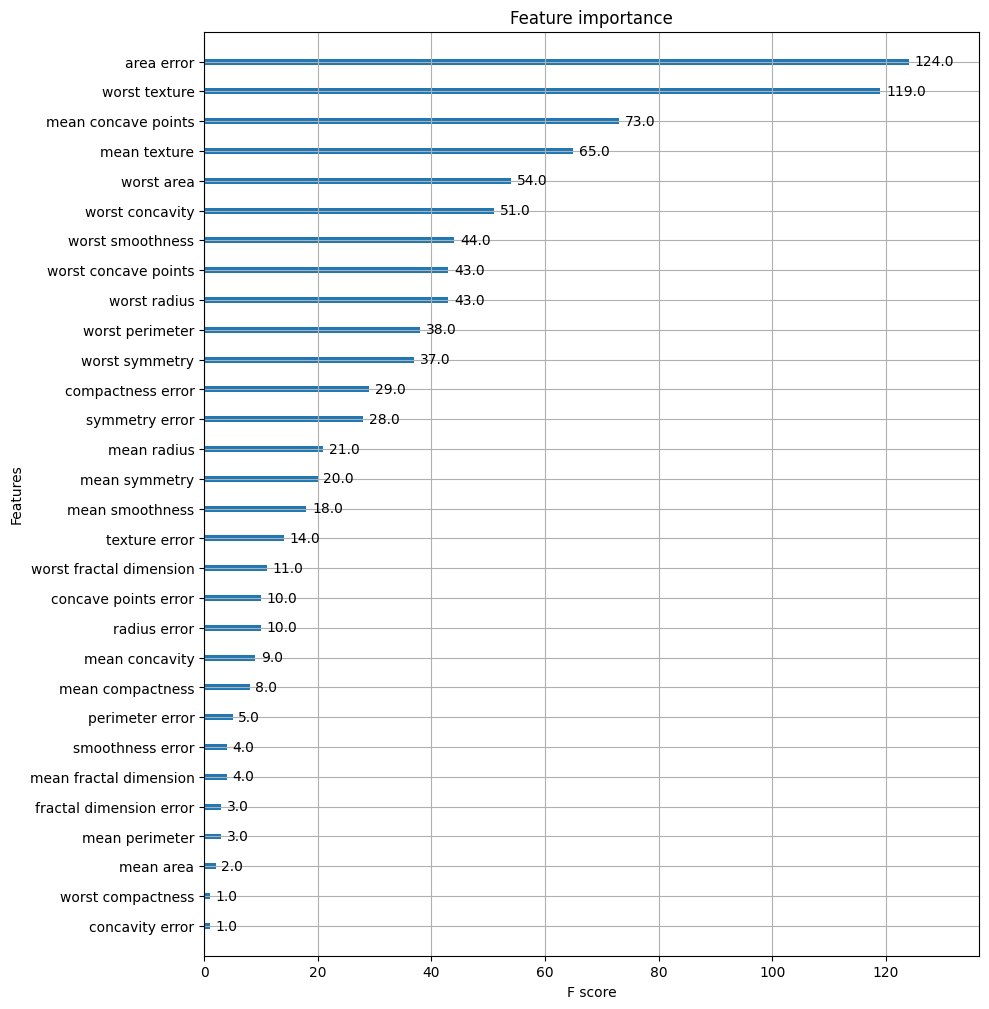

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

### 사이킷런 래퍼 XGBoost의 개요 및 적용

사이킷런 래퍼는 사이킷런과 호환돼 편리하게 사용 가능
- Estimator와 동일하게 `fit()`과 `predict()`만으로 학습과 예측 가능, 사이킷런의 유틸리티 GridSearchCV, Pipeline 그대로 사용 가능
- 분류 XGBClassifier, 회귀 XGBRegressor

In [24]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [25]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9947


- 앞 예제의 파이썬 래퍼 XGBoost보다 좋은 평가 결과 나옴
- 위스콘신 데이터 세트 개수가 워낙 작은데, 이전에는 조기 중단을 위해 최초 학습 데이터인 X_train을 다시 학습용 X_tr과 X_val로 분리하면서 최종 학습 데이터 건수가 작아지기 때문에 발생한 것으로 추정

사이킷런 래퍼 XGBoost에 조기 중단 수행

In [31]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=50, eval_metric="logloss")
# early_stopping_rounds 평가 지표가 향상될 수 있는 반복 횟수
# eval_metric 조기 중단을 위한 평가 지표
evals = [(X_tr, y_tr), (X_val, y_val)]
# 파이썬 래퍼와 다르게 학습과 검증을 의미하는 문자열 필요 없음
# 앞 튜플이 학습용 데이터, 뒤의 튜플이 검증용 데이터로 자동 인식
xgb_wrapper.fit(X_tr, y_tr,
                eval_set=evals, verbose=True)
# eval_set 성능 평가를 수행할 데이터 세트
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

- n_estimators가 400이지만 400번 반복 하지 않음

In [32]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9961


조기 중단값 너무 급하게 줄이면 예측 성능 저하될 우려 큼

In [33]:
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, early_stopping_rounds=10, eval_metric="logloss")
# early_stopping_rounds 평가 지표가 향상될 수 있는 반복 횟수
# eval_metric 조기 중단을 위한 평가 지표
evals = [(X_tr, y_tr), (X_val, y_val)]
# 파이썬 래퍼와 다르게 학습과 검증을 의미하는 문자열 필요 없음
# 앞 튜플이 학습용 데이터, 뒤의 튜플이 검증용 데이터로 자동 인식
xgb_wrapper.fit(X_tr, y_tr,
                eval_set=evals, verbose=True)
# eval_set 성능 평가를 수행할 데이터 세트
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.62480	validation_1-logloss:0.63104
[1]	validation_0-logloss:0.58674	validation_1-logloss:0.60478
[2]	validation_0-logloss:0.55226	validation_1-logloss:0.58223
[3]	validation_0-logloss:0.52086	validation_1-logloss:0.56184
[4]	validation_0-logloss:0.49192	validation_1-logloss:0.54118
[5]	validation_0-logloss:0.46537	validation_1-logloss:0.52223
[6]	validation_0-logloss:0.44029	validation_1-logloss:0.50287
[7]	validation_0-logloss:0.41666	validation_1-logloss:0.48620
[8]	validation_0-logloss:0.39525	validation_1-logloss:0.46974
[9]	validation_0-logloss:0.37542	validation_1-logloss:0.45497
[10]	validation_0-logloss:0.35701	validation_1-logloss:0.44131
[11]	validation_0-logloss:0.33982	validation_1-logloss:0.43134
[12]	validation_0-logloss:0.32297	validation_1-logloss:0.41972
[13]	validation_0-logloss:0.30725	validation_1-logloss:0.40902
[14]	validation_0-logloss:0.29327	validation_1-logloss:0.39883
[15]	validation_0-logloss:0.27946	validation_1-logloss:0.38968
[1

엥 정확도가 낮아져야 하는데 왜 더 높아졌을까?

피처의 중요도 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

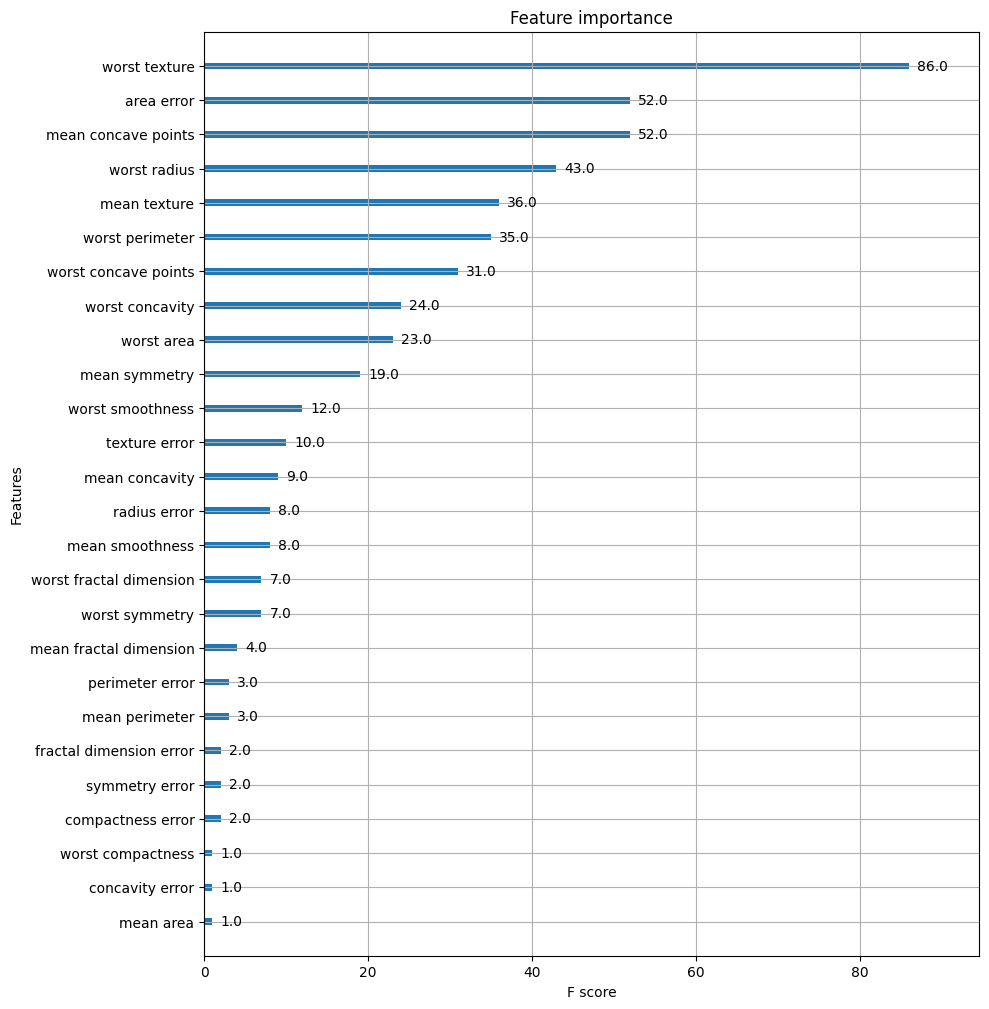

In [34]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)

## 4.7 LightGBM

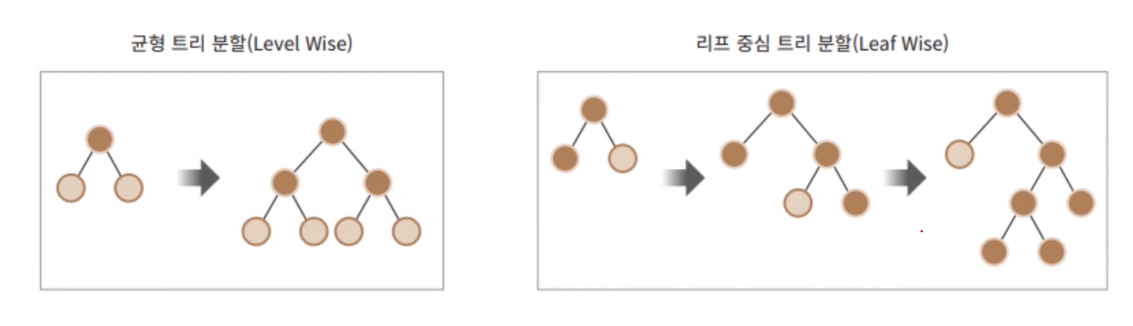

LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식 사용
- 트리의 균형 맞추지 않고, 최대 손실 값(max delta loss) 가지는 리프 노드를 지속적으로 분할
- 학습을 반복할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화 가능

LightGBM의 XGBoost 대비 장점
- 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

파이썬 패키지 `lightgbm`
- 파이썬 래퍼용, 사이킷런 래퍼 모듈 모두 가지고 있음
- 사이킷런 래퍼 LightGBM 클래스: 분류 LGBMClassifier, 회귀 LGBMRegressor 클래스
- 사이킷런의 기반 Estimator 상속 받아 fit(), predict() 기반 학습 및 예측과 사이킷런 제공 유틸리티 활용 가능

In [37]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [1]:
import lightgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
print(lightgbm.__version__)

3.3.2


### LightGBM 적용 – 위스콘신 Breast Cancer Prediction

In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

- 조기 중단으로 111번 반복까지만 수행하고 학습 종료

학습된 LightGBM 모델 기반으로 예측 성능 평가

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


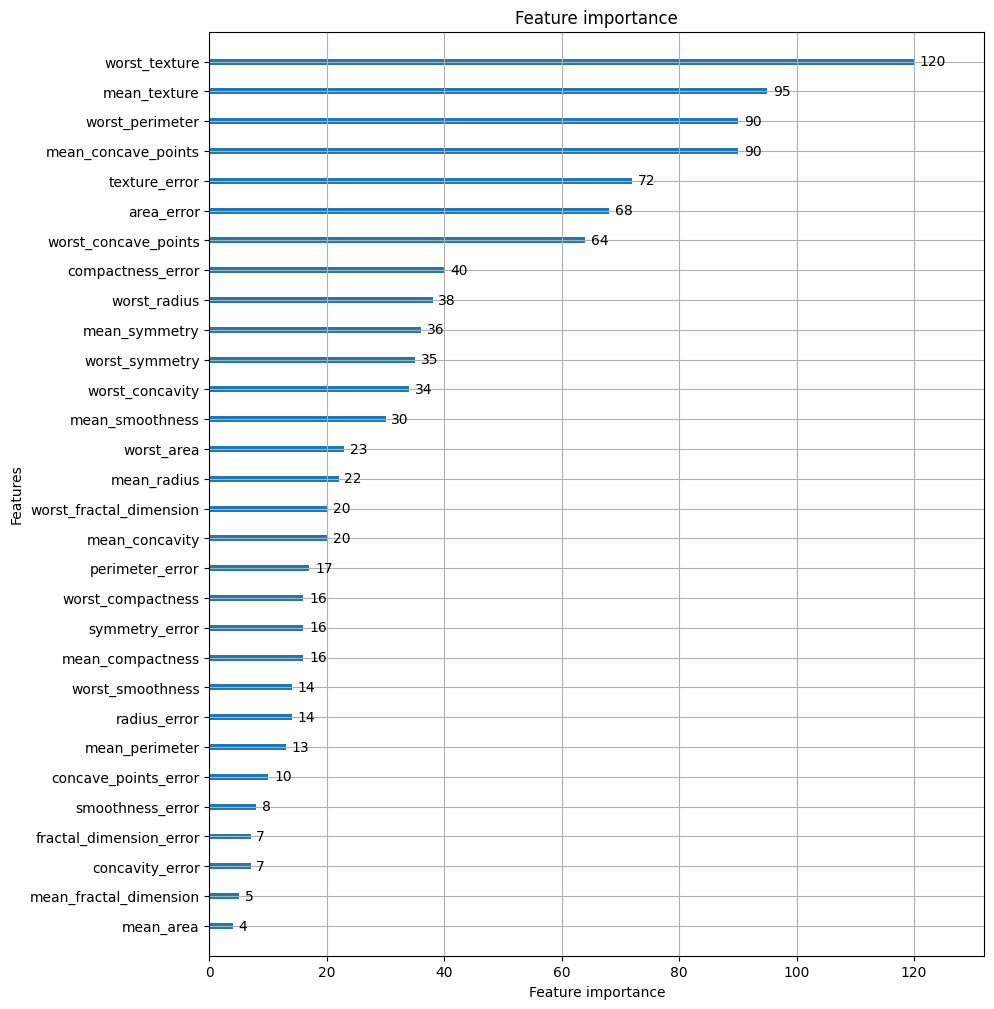

In [6]:
# plot_importance( )를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

## 4.8 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

지금까지는 하이퍼 파라미터 튜닝을 위해서 사이킷런에서 제공하는 Grid Search 방식을 적용했음
- 튜닝해야 할 하이퍼 파라미터 개수가 많을 경우 최적화 수행 시간 오래 걸림
- 대용량 학습 데이터에 XGBoost나 LightGBM의 하이퍼 파라미터 튜닝 시 다른 방식 적용

### 베이지안 최적화 개요

베이지안 최적화
- 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식

베이지안 확률 기반
- 새로운 사건의 관측이나 새로운 샘플 데이터를 기반으로 사후 확률을 개선해 나감
- 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 낙면서 최적 함수 모델 만든다.

베이지안 최적화를 구성하는 두 가지 중요 요소
- 대체 모델(Surrogate Model)
  - 획득 함수로부터 최적 함수를 예측할 수 있는 입력값 추천 받은 뒤 이를 기반으로 최적 함수 모델 개선
  - 여기서 입력값은 하이퍼 파라미터
  - 즉, 획득 함수가 계산한 하이퍼 파라미터를 입력받으면서 개선됨
- 획득 함수(Acquisition Function)
  - 개선된 대체 모델을 기반으로 최적 입력값 계산(더 정확한 하이퍼 파라미터 계산)
  

베이지안 최적화 단계

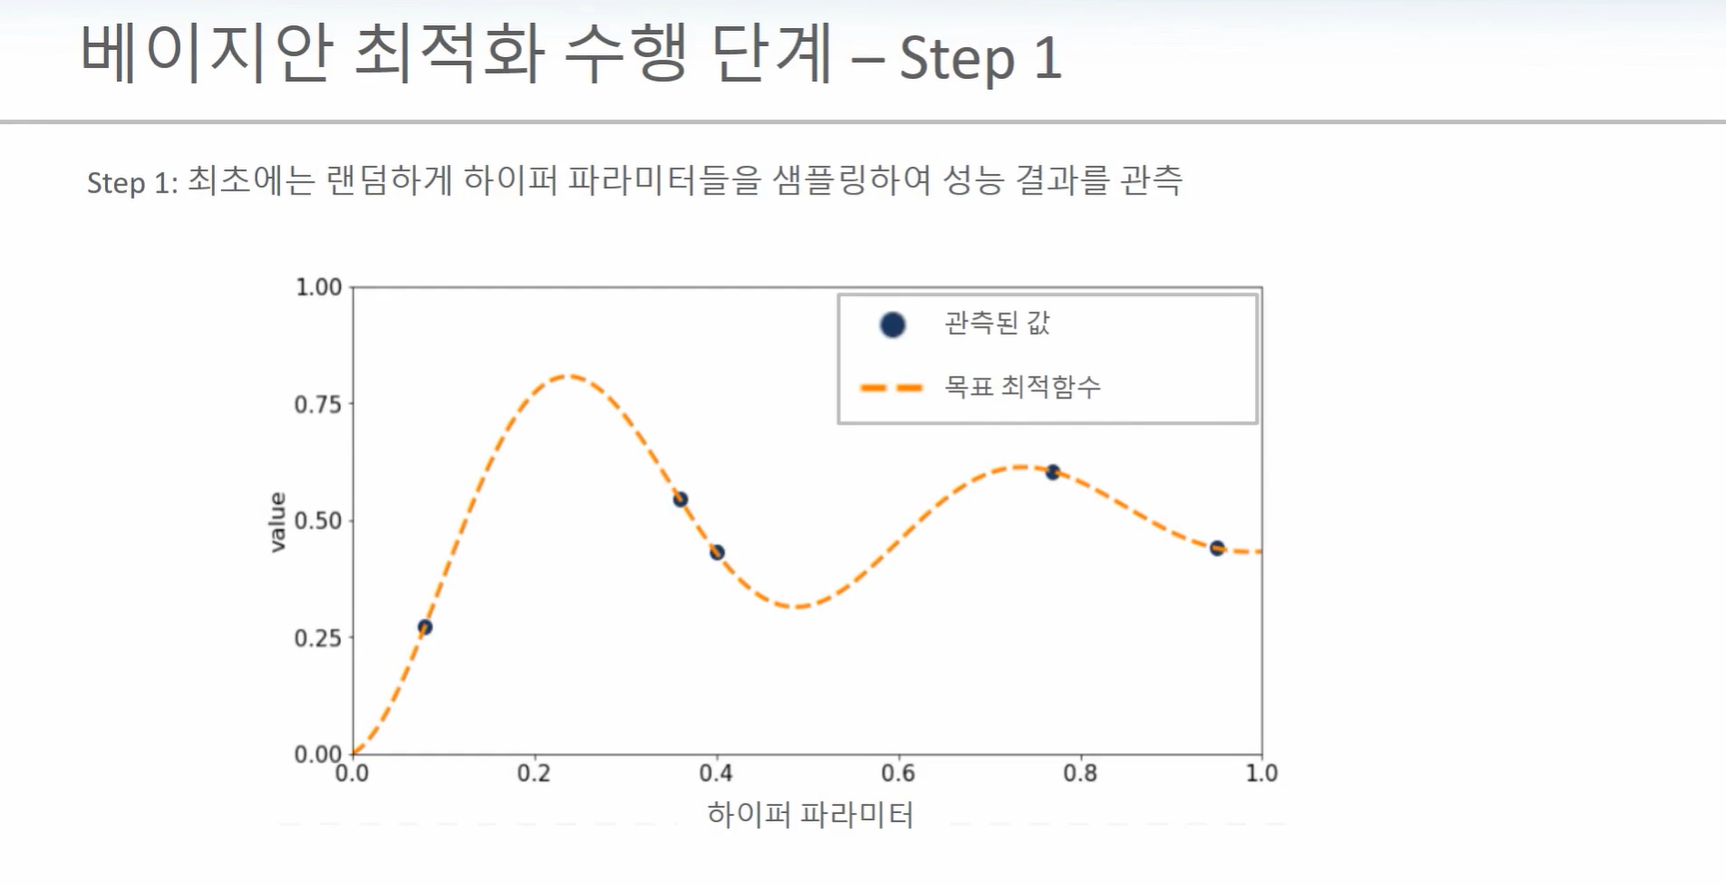

- 검은색 원: 특정 하이퍼 파라미터가 입력되었을 때 관측된 성능 지표 결괏값
- 주황색 사선: 찾아야 할 목표 최적 함수

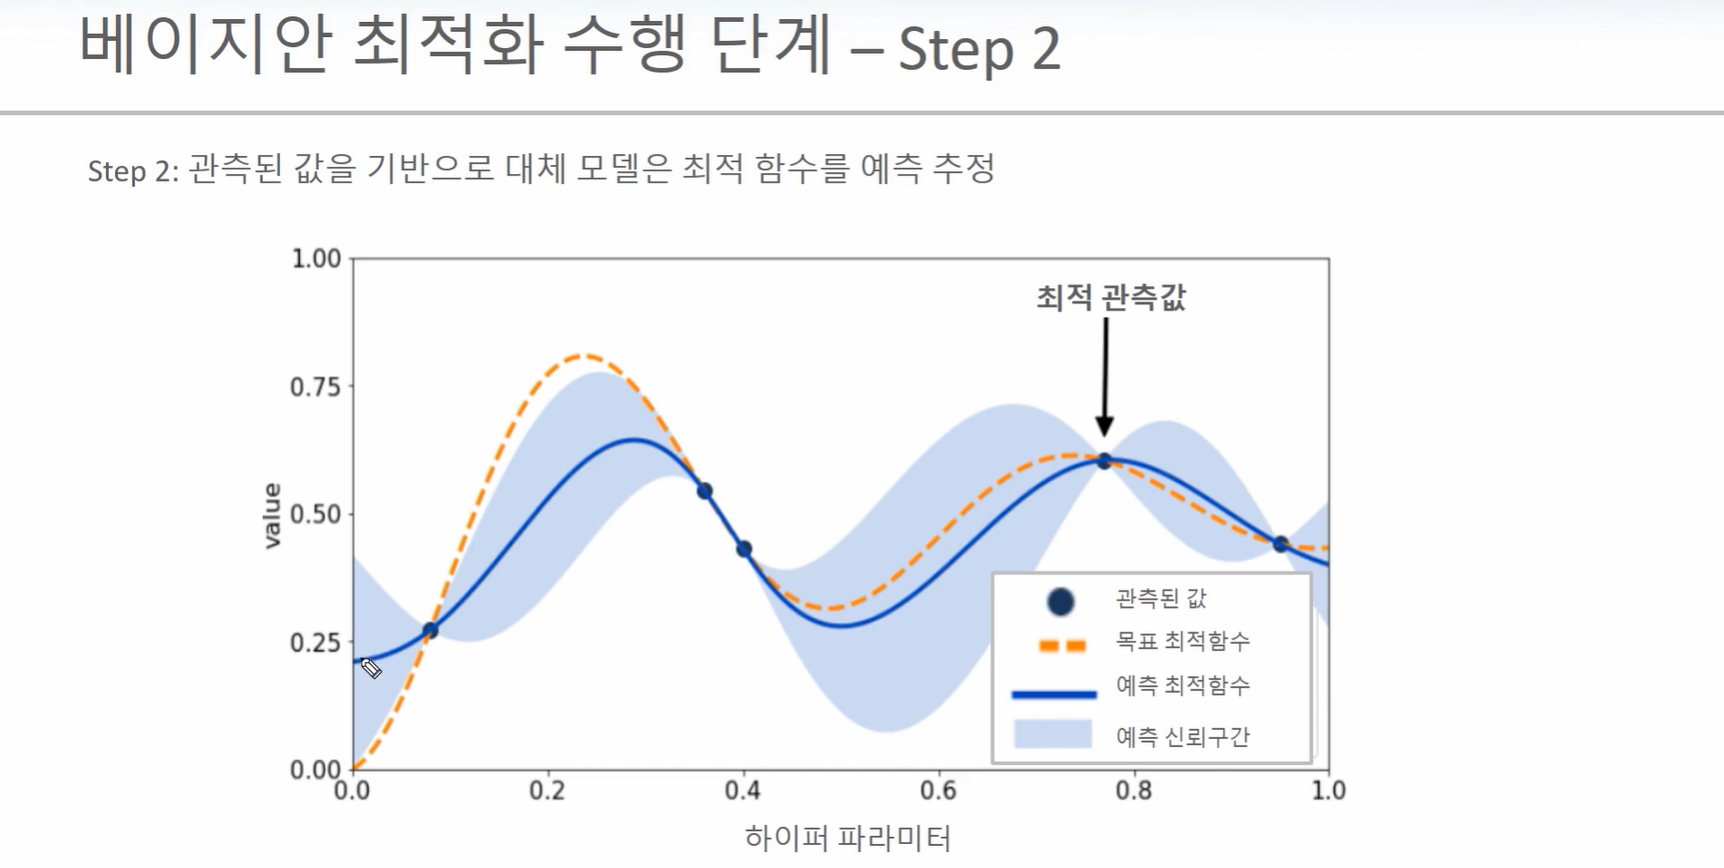

- 파라색 실선: 대체 모델이 추정한 최적 함수
- 최적 관측값: y축 value에서 가장 높은 값을 가질 때의 하이퍼 파라미터

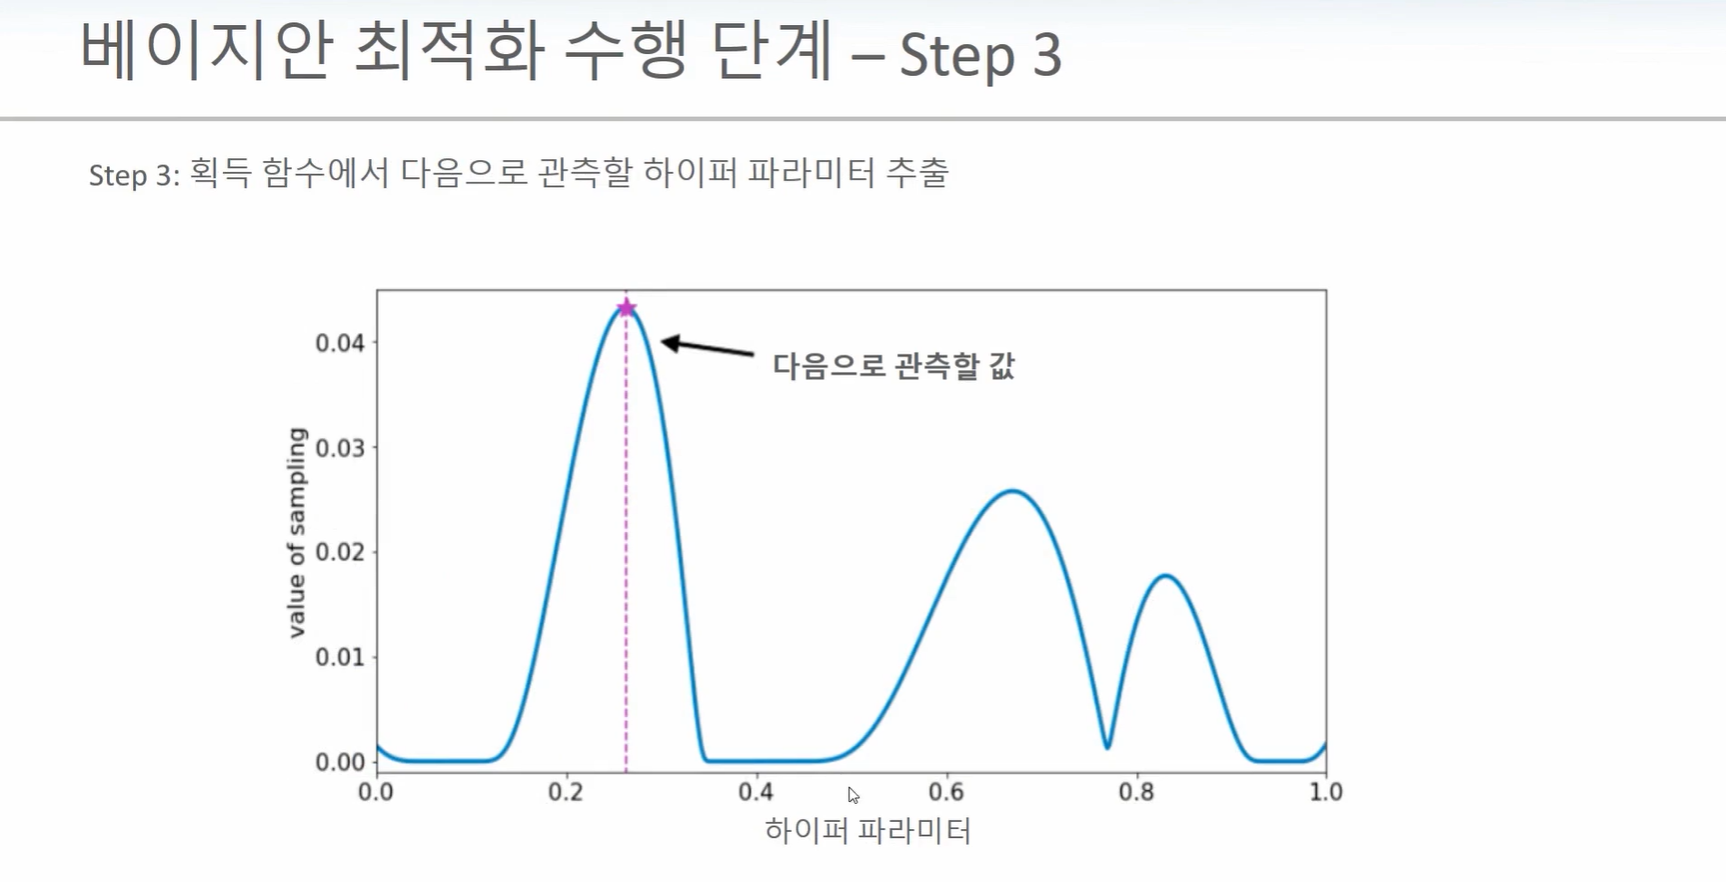

- 획득 함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관측할 하이퍼 파라미터를 대체 모델이 전달

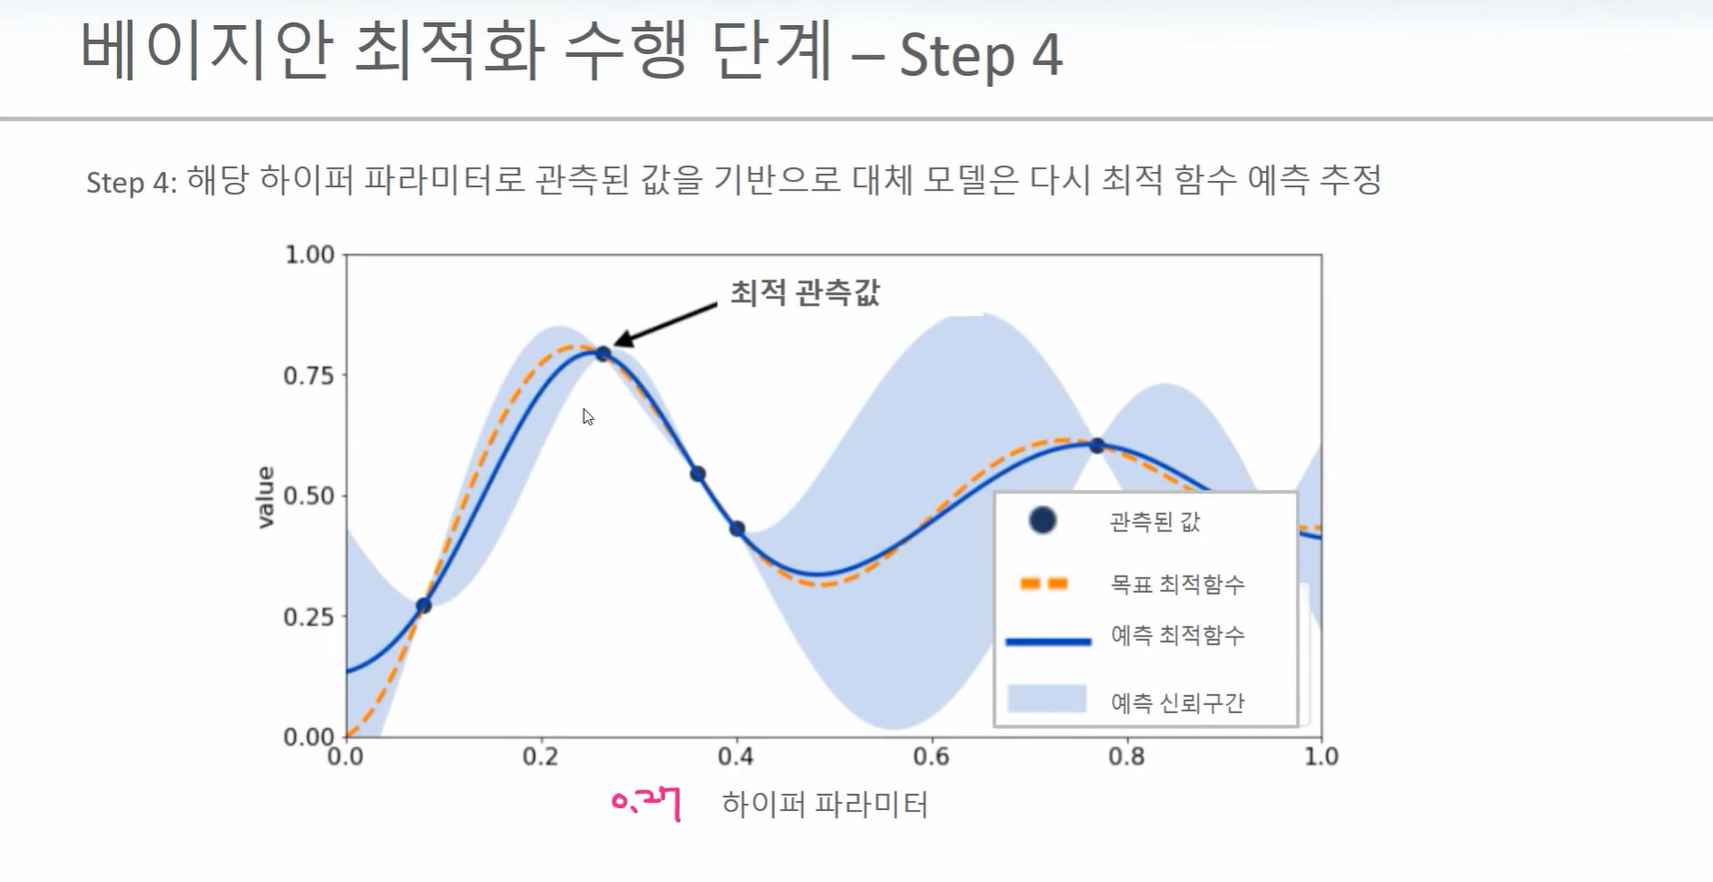

Step 3과 Step 4를 특정 횟수 반복하면 대체 모델의 불확실성 개선되고 점차 정확한 최적 함수 추정 가능

대체 모델은 최적 함수 추정할 때 다양한 알고리즘 사용
- 일반적으로 가우시안 프로세스(Gaussian Process) 적용
- 뒤에 나올 HyperOpt는 가우시안 프로세스가 아닌 트리 파르젠 Estimator(TPE, Tree-structure Parzen Estimator) 사용

### HyperOpt 사용하기

유의할 점: 다른 패키지와 다르게 목적 함수 반환 값의 최댓값이 아닌 최솟값을 가지는 최적 입력값을 유츄

In [7]:
import hyperopt

print(hyperopt.__version__)

0.2.7


입력 변수명과 입력값 검색 공간은 파이썬 딕셔너리 형태로 설정
- 키(key)값으로 입력 변수명, 밸류(value)값으로 해당 입력 변수의 검색 공간

In [8]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정.
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1) }

목적 함수 생성
- 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
- search_space로 지정된 딕셔너리에서 x 입력 변숫값과 y 입력 변숫값을 추출하여 retval = x**2 - 20*y로 계산한 값을 반환

In [9]:
from hyperopt import STATUS_OK

# 목적 함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

`HyperOpt`의 `fmin(objective, space, algo, max_evals, trials)`

목적 함수의 반환값이 최소가 될 수 있는 최적의 입력값을 베이지안 최적화 기법에 기반하여 찾아 줌

In [10]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
# fn: 목적 함수, space: 검색 공간 딕셔너리, algo: 베이지안 최적화 적용 알고리즘(Tree of Parzen Estimator), max_evlas: 시도 횟수
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.default_rng(seed=0)) # trials: 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과 저장, rstate: 랜덤 시드 값
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 418.38trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


- 입력 변수 x의 공간 -10 ~ 10, y의 공간 -15 ~ 15에서 복적 함수의 반환값을 x**2 - 20*y로 설정했으므로 x는 0에 가까울수록, y는 15에 가까울수록 최소로 근사됨
- best: {'x': -4.0, 'y': 12.0}
- 5번의 수행으로 어느 정도 최적값에 다가섬

In [11]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 604.16trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


- 완벽한 정답인 x=0 도출 못함
- x 21개의 경우의 수, y 31개 경우의 수
- 그리드 서치와 같이 순차적으로 x, y 변숫값 입력해서 찾는다면 최대 21X31=651회의 반복이 필요
- 베이지안 최적화 이용해서 20회 반복마능로 일정 수준의 최적값 근사

### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

- 적용해야 할 하이퍼 파라미터와 검색 공간 설정
- 목적 함수에서 XGBoost 학습 후 예측 성능 결과를 반환 값으로 설정
- fmin() 함수에서 목적 함수를 하이퍼 파라미터 검색 공간의 입력값들을 사용하여 최적의 예측 성능 결과 반환하는 최적 입력값들 결정

In [12]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

In [13]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

검색 공간 설정

In [14]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색.
# max_depth와 min_child_weight는 정수형 하이퍼 파라미터이므로 hp.quniform() 사용
# hp.quniform(label, low, high, q): label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정
# learning_rate와 colsample_bytree는 hp.uniform() 사용
# hp,uniform(label, low, high): 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                   }

목적 함수 설정
- 검색 공간에서 서정한 하이퍼 파라미터들을 입력받아 XGBoost를 학습하고 평가지표를 반환할 수 있도록 구성

유의사항
- 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값
- 이들을 XGBoostClassifier의 정수형 하이퍼 파라미터갑승로 설정할 때는 정수형으로 형변환을 해야 함
- `XGBoostClassifier(max_depth=int(search_space['max_depth'])))`
- HyperOpt의 목적 함수는 최솟값 반환하도록 최적화해서 성능 값 클수록 좋은 성능 지표일 경우 -1 곱해야 함
- 예) 목적 함수의 반환값을 정확도로 한다면 정확도는 값이 클수록 좋은 성능 지표이므로 -1 곱해줌

목적 함수 `objective_func()`
- 반환값은 교차 검증 기반의 평균 정확도(accuracy)
- 3개의 교차 검증 세트로 정확도 반환하도록 `cross_val_score()` 적용
- XGBoost나 LightGBM에 `cross_val_score()` 적용하면 조기 중단 지원 안 됨
- KFold로 학습과 검증용 데이터 세트 만들어서 직접 교차 검증 수행해야 함

In [15]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

`fmin()` 이용해 최적 하이퍼 파라미터 도출

In [16]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,  # 목적함수
            space=xgb_search_space, # 하이퍼 파라미터 검색 공간
            algo=tpe.suggest, # 베이지안 최적화 적용 알고리즘
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trial_val, rstate=np.random.default_rng(seed=9)) # 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과 저장, 랜덤 시드
print('best:', best)

100%|██████████| 50/50 [00:24<00:00,  2.05trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


- 정수형 하이퍼 파라미터인 max_depth, min_child_weight가 실수형 값으로 도출되었음에 유의

`fmin()`으로 추출된 최적 하이퍼 파라미터를 직접 XGBClassifier에 인자로 입력하기 전에 정수형 하이퍼 파라미터는 정수형으로 형 변환을, 실수형 하이퍼 파라미터는 소수점 5자리까지만 변환 후 확인

In [17]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.50265, learning_rate:0.19828, max_depth:15, min_child_weight:1


도출된 최적 하이퍼 파라미터들을 이용해서 XGBClassifier 재학습 후 성능 평가 결과 확인

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [19]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5),
                            eval_metric='logloss',
                            early_stopping_rounds=50
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr,
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.51230	validation_1-logloss:0.55948
[1]	validation_0-logloss:0.40697	validation_1-logloss:0.47575
[2]	validation_0-logloss:0.32809	validation_1-logloss:0.41760
[3]	validation_0-logloss:0.27049	validation_1-logloss:0.37988
[4]	validation_0-logloss:0.22671	validation_1-logloss:0.34438
[5]	validation_0-logloss:0.19305	validation_1-logloss:0.31788
[6]	validation_0-logloss:0.16589	validation_1-logloss:0.30717
[7]	validation_0-logloss:0.14300	validation_1-logloss:0.30056
[8]	validation_0-logloss:0.12355	validation_1-logloss:0.29707
[9]	validation_0-logloss:0.10737	validation_1-logloss:0.28298
[10]	validation_0-logloss:0.09355	validation_1-logloss:0.26801
[11]	validation_0-logloss:0.08250	validation_1-logloss:0.26738
[12]	validation_0-logloss:0.07357	validation_1-logloss:0.26220
[13]	validation_0-logloss:0.06572	validation_1-logloss:0.26240
[14]	validation_0-logloss:0.05892	validation_1-logloss:0.25570
[15]	validation_0-logloss:0.05247	validation_1-logloss:0.25186
[1

왜 정확도가 더 낮아졌지?

위스콘신 유방암 데이터 세트의 건수가 569개로 매우 작고, 이 작은 데이터에서 학습, 검증, 테스트 데이터 세트를 분할하여 하이퍼 파라미터 튜닝과 평가를 했기 때문에 불안정한 성능 결과 보일 수 있음